#RESEACH QUESTION:

- Can a professor’s overall rating and difficulty level predict the instructor’s grade point average? With this project, we would like to see if there is a correlation between a professor’s difficulty and rating, and their average grade point average. Down the line, we could fit a multi-variable regression in order to predict what a professor’s median grade would be depending on what the difficulty and rating of that professor was.	
- How do a professor's ratings impact the grade distribution of the class?
- Do the ratings and difficulty level actually reflect how well students do?

In [2]:
#imports and settings
import pandas as pd
import numpy as np
import ratemyprofessor
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from sklearn.linear_model import LinearRegression

#DATA OVERVIEW:

We are using two initial datasets. The first dataset is web scraped from the website https://www.ratemyprofessors.com/ using the web scraping API from https://pypi.org/project/RateMyProfessorAPI/. The second dataset is taken from the csv at https://docs.google.com/spreadsheets/d/1817WfShAi7RHWWJR2c95YUgX37TkjUsLQMYSWhTy9PQ/edit#gid=1481854826. This is downloaded and then converted into a data frame using the pandas python library.
The raw data set of median grades by class has 1010 rows, including column names, NaN, and unpolished data. The dataset is grouped by classes, and the columns are "Professor" (professor last names), "A+" (median grades per class) by letter grade, "Semester (Ex: SP21)" (specifying semester), "# of Students" (number of students taking each class), "Notes" (additional imformation of each class).

Link to the dataset: https://docs.google.com/spreadsheets/d/1817WfShAi7RHWWJR2c95YUgX37TkjUsLQMYSWhTy9PQ/edit#gid=1481854826

In [3]:
#reading the csv file of median grades spreadsheet by course 
#and professor and printing the first few rows of the raw dataset
df = pd.read_csv("classes.csv")

print(df.shape, '\n', df.columns)
df.head()

(1009, 7) 
 Index(['Unnamed: 0', 'Professor', 'A+', 'Semester (Ex: SP21)', '# of Students',
       'Notes', '@'],
      dtype='object')


,Unnamed: 0,Professor,A+,Semester (Ex: SP21),# of Students,Notes,@
0,NaN,Various (FWS),C-,FA21,64,2-3 graded essays & interesting assigned readings,NaN
1,AAS 2130,Chang,A,FA21,52,"crosslisted with AMST 2640, HIST 2640",NaN
2,AAS 2130,Moghimi,A,FA21,NaN,NaN,NaN
3,AAS 2130,van Es,A+,SP23,239,,NaN
4,AEM 1200,Sauer,A-,SP22,326,NaN,NaN


**DATA CLEANING:**

We cleaned the raw data set of median grades by class. This is just a breif overview of what we did. Significanlty more details are in later markdown cells

We did this thrugh a couple steps: selecting relevant columns, cleaning out NaNs, remapping a quantitative value over letter grades, and splitting up shared-professor names (more details in later markdowns). 

We also combined this with data from RateMyProfessor before further cleaning it. 

In [4]:
#selecting columns we need (Professor, Grade, Semester, Students)
#for merging the median grade dataset and the data we obtained 
#from the RateMyProfessor API
df = duckdb.sql("""SELECT Professor, "A+" as Grade , \
    "Semester (Ex: SP21)" AS Semester, "# of Students" \
        as Students
                FROM df""").df()
df.head()


,Professor,Grade,Semester,Students
0,Various (FWS),C-,FA21,64
1,Chang,A,FA21,52
2,Moghimi,A,FA21,NaN
3,van Es,A+,SP23,239
4,Sauer,A-,SP22,326


In [5]:
#dropping NaNs in columns of Professor and Grade, reducing the number
#of rows from 1009 to 988 and printing the shape of the dataset
df = df.dropna(subset = ["Professor", "Grade"])
df.shape

(988, 4)

In [6]:
#converting letter grades from Grades into Cornell's GPA scale
#for an easier data operation later and saving them in a new 
#column named Grade_point
df['Grade_point'] = df['Grade'].map({'A+': 4.3, 'A': 4.0, \
    'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, \
    'C': 2.0,'C-':1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.7, 'F': 0.0})
df.head()

,Professor,Grade,Semester,Students,Grade_point
0,Various (FWS),C-,FA21,64,1.7
1,Chang,A,FA21,52,4.0
2,Moghimi,A,FA21,NaN,4.0
3,van Es,A+,SP23,239,4.3
4,Sauer,A-,SP22,326,3.7


We noticed that in some cases, classes with multiple professors had both names included in the Professor column wth a "/" or "," or "+" seperating them. For example, in row 32 in the output below, we can see that Professors Huffaker and Tunbar taught that course, but were included together as "Hukkafer/Tunbar". This is a problem for the API we used since "Hukkafer/Tunbar" would be interperated as one name, and thus no corresponding rating/difficulty would be obtained. The same applies to "Fromme, Liu" in row 33 (only this time the names are seperated by a comma instead). To fix this, we created a loop that goes through the Professor column and turns each such cell into a list using the .split() function.

In [7]:

# This for loop iterates through the proffessor column,
#checks if the cell contains a "/", ", ", or " + ". 

#Make a list that will become a the new column "split_professor"
split_professor = []
#iterate though column
for i in range(len(df["Professor"])):
    #Save professor name
    data = df.iloc[i]["Professor"]
    #Check if operator is in a professor name. If so, split it
    # and append it to split_professor
    if "/" in data:
        split_professor.append(df.iloc[i]["Professor"].split("/"))    
    elif "," in data:
        split_professor.append(df.iloc[i]["Professor"].split(", "))
    elif "+" in data:
        split_professor.append(df.iloc[i]["Professor"].split(" + "))
    #If no operator in cell, just append original Professor name 
    #to new list
    else: 
        split_professor.append(data)
#add the list as a new column of df
df["split_professor"] = split_professor
df.head(50)

,Professor,Grade,Semester,Students,Grade_point,split_professor
0,Various (FWS),C-,FA21,64,1.7,Various (FWS)
1,Chang,A,FA21,52,4.0,Chang
2,Moghimi,A,FA21,NaN,4.0,Moghimi
3,van Es,A+,SP23,239,4.3,van Es
4,Sauer,A-,SP22,326,3.7,Sauer
5,Riley,C+,SP22,3596,2.3,Riley
6,Moghimi,A,SP22,145,4.0,Moghimi
7,Van Es,A+,FA20,252,4.3,Van Es
9,Szpiro,A-,FA21,170,3.7,Szpiro
12,Alexander,B+,SP21,260,3.3,Alexander


In [8]:
#Used Pandas Explode function to take each "split list" 
#(i.e [Huffaker, Tumbar] in row 32 & [Fromme, Liu] in row 33)
#and create 2 rows, each with one of the elements of the list,
# which in our case are professor names
#[Huffaker, Tumbar] will become 2 new rows, one with just 
#Huffaker and one with just Tumbar. We can now input these
# into the API and get data. 
#Refer to rows 32 and 33 for example.
df = df.explode('split_professor')
#print shape to show that there is an increase in rows after explode.
print(df.shape)
df.head(40)


(1091, 6)


,Professor,Grade,Semester,Students,Grade_point,split_professor
0,Various (FWS),C-,FA21,64,1.7,Various (FWS)
1,Chang,A,FA21,52,4.0,Chang
2,Moghimi,A,FA21,NaN,4.0,Moghimi
3,van Es,A+,SP23,239,4.3,van Es
4,Sauer,A-,SP22,326,3.7,Sauer
5,Riley,C+,SP22,3596,2.3,Riley
6,Moghimi,A,SP22,145,4.0,Moghimi
7,Van Es,A+,FA20,252,4.3,Van Es
9,Szpiro,A-,FA21,170,3.7,Szpiro
12,Alexander,B+,SP21,260,3.3,Alexander


In [9]:
#Selecting relevant rows and grouping by professor names to 
#account for professors who teach multiple classes and thus 
#show up multiple times. Also makes code more efficient.
# Take the average grade that teacher had over all of their 
#courses and make a new row Average_grade. 
df = duckdb.sql("""SELECT split_professor AS Professor,
                AVG(Cast(Grade_point AS float)) 
                AS Average_grade 
                FROM df GROUP BY split_professor """).df()
df.head(40)

,Professor,Average_grade
0,Various (FWS),3.856250
1,Chang,4.000000
2,Moghimi,4.000000
3,van Es,4.000000
4,Sauer,3.700000
5,Riley,3.325000
6,Van Es,4.000000
7,Szpiro,3.566667
8,Alexander,3.575000
9,MacMahon,3.300000


For this project, we used an API called RateMyProfessor API that takes in a school name and a professor, and returns a professor object with getter methods to return ratings, difficulty, number of ratings, etc. We iterated through professor names, and input them into the API along with Cornell University as the school name. We then made new columns with the ratings, difficulties, and number of ratings of each corresponding professor. If the professor name had no match in RateMyProfessor, the name was misspelled/misinputted, or the 'professor' name in the cell was not a human name (such as "Various (FWS)") we just assigned their ratings, difficulties, and num_reviews to 0. We will elaborate on this later. 

In [16]:
#making lists that will eventually become columns
ratings, difficulty, num_reviews = [],[],[]
#iterating through Professor column
for i in range(len(df["Professor"])):
    #Plugging in professor name and school name to API,
    #returns a Professor object that contains all 
    #corresponding ratemyprofessor data 
    #Using try/except to filter out when a professor 
    #name input was found or not. If no corresponding 
    #professor was found, object will have not be able
    #to return data and will return an error, so we 
    #use try/except.
    try:
        prof = ratemyprofessor.get_professor_by_school_and_name\
            ((ratemyprofessor.get_school_by_name\
                ("Cornell University")), df.iloc[i]["Professor"])
        #append returned values for rating, difficulty, and 
        #num_ratings to lists.
        ratings.append(prof.rating)
        difficulty.append(prof.difficulty)
        num_reviews.append(prof.num_ratings)
    except:
        #if no corresponding ratemyprofessor data is found,
        # the append 0's to all lists instead. 
        ratings.append(0)
        difficulty.append(0)
        num_reviews.append(0)
    
#create new columns with the created lists. Named after the data
# they contain ("df[Ratings]" contains ratings)
df["Ratings"] = ratings
df["Difficulty"] = difficulty
df["Num_reviews"] = num_reviews

In [10]:
#print first 40 rows to see data 
df.head(40)

,Professor,Average_grade
0,Various (FWS),3.856250
1,Chang,4.000000
2,Moghimi,4.000000
3,van Es,4.000000
4,Sauer,3.700000
5,Riley,3.325000
6,Van Es,4.000000
7,Szpiro,3.566667
8,Alexander,3.575000
9,MacMahon,3.300000


Now, we want to clean the data of 0's, and any professor who has less than 5 reviews, from the num_reviews column. Since there are 0's for all rows where the professor name had no matches, removing 0's would remove those instances. Also, it would remove naturally occuring 0's, which we want it to do. If a professor's name was found, but they had less than 5 ratings, we don't want to include them in our dataset either. 

In [11]:
#Removes all rows that have "num_reviews" == 0.
df= df[df['Num_reviews'] >= 5]
df.head(40)
#print shape to show we cut out rows.
df.shape

KeyError: 'Num_reviews'

We noticed that there was an outlier with professor Musser, where he had an abnormal number of reviews. When we investigated, we realized that he had over 1000 1-star reveiws, and after looking at the reviews, they seem to have been systematically generated in order to lower professor Musser's rating. There were an abnoraml number of reviews on the same day, with the same rating, and with very similar writing styles. As a result, we decided to remove it. 

In [325]:
#removing outliers
df = df[df['Num_reviews'] < 1000]

#EXPLORATORY DATA ANALYSIS:

Average and standard deviation grade of Cornell in terms of GPA
Pie chart of grades, ex. A+, A, A-, etc.
Scatterplot of ratings and difficulty
Scatterplot of rating and GPA
Scatterplot of difficulty and GPA
Covariance matrix of ratings, difficulty, and GPA
Distribution of average GPA by rating 
Distribution of average GPA by difficulty
Multivariable regression model 

In [12]:
avg_grade = df['Average_grade'].mean()
std_grade = df['Average_grade'].std()
print(f'Average grade of Cornell: {avg_grade}')
print(f'Standard Deviation of grade of Cornell: {std_grade}')

Average grade of Cornell: 3.676180542334579
Standard Deviation of grade of Cornell: 0.34591728810588235


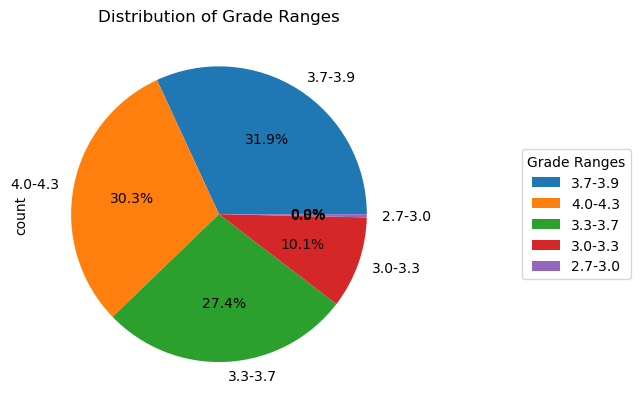

In [327]:
#Pie chart of grades, ex. A+, A, A-, etc.

bins = [1.3, 1.7, 2.0, 2.3, 2.7, 3.0, 3.3, 3.7, 3.9, 4.3]

#Bin the grades using pandas.cut
#Round values to 2 decimal places
df['Average_grade_rounded'] = df['Average_grade'].round(2)  
df['Grade_Ranges'] = pd.cut(df['Average_grade_rounded'], bins,\
        right=False, 
        labels=['1.3-1.7','1.7-2.0','2.0-2.3', '2.3-2.7', '2.7-3.0', \
                '3.0-3.3', '3.3-3.7', '3.7-3.9', '4.0-4.3'])

# Get the value counts of the binned grades
grades_count = df['Grade_Ranges'].value_counts()

# Plot
fig, ax = plt.subplots()
grades_count.plot(kind='pie', title='Distribution of Grade Ranges', \
        autopct='%1.1f%%', ax=ax)

# Add a legend on the right side
ax.legend(title="Grade Ranges", loc="center left", \
        bbox_to_anchor=(1.3, 0.5))

plt.show()

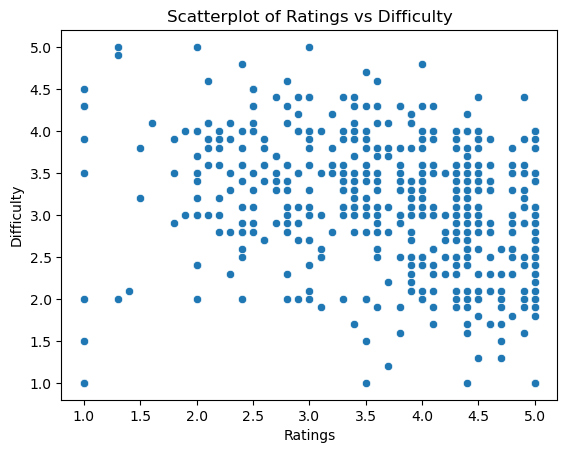

In [328]:
# 3. Scatterplot of ratings and difficulty
sns.scatterplot(x=df['Ratings'], y=df['Difficulty'])
plt.title('Scatterplot of Ratings vs Difficulty')
plt.show()

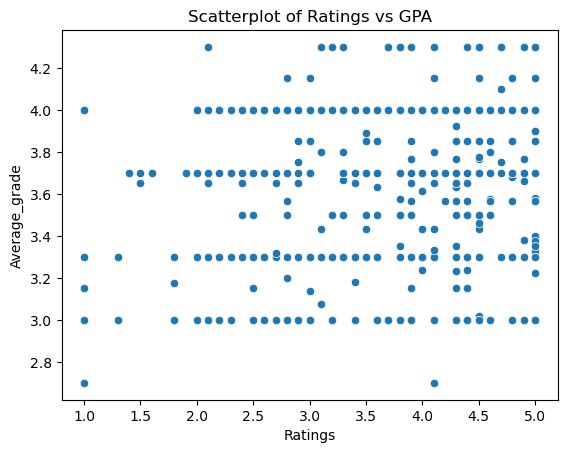

In [329]:
# 4. Scatterplot of rating and GPA
sns.scatterplot(x=df['Ratings'], y=df['Average_grade'])
plt.title('Scatterplot of Ratings vs GPA')
plt.show()

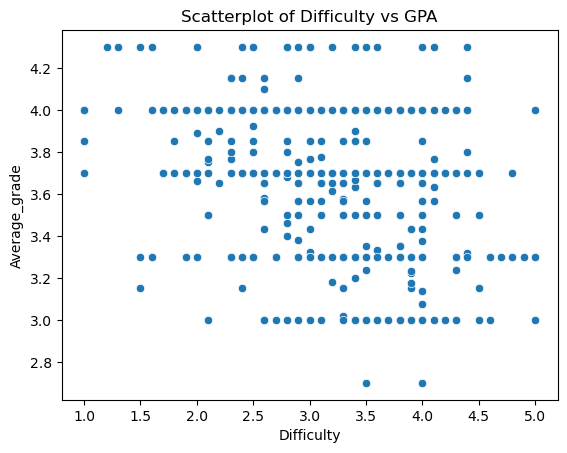

In [330]:
# 5. Scatterplot of difficulty and GPA
sns.scatterplot(x=df['Difficulty'], y=df['Average_grade'])
plt.title('Scatterplot of Difficulty vs GPA')
plt.show()

In [331]:
# 6. Covariance matrix of ratings, difficulty, and GPA
cov_matrix = df[['Ratings', 'Difficulty', 'Average_grade']].cov()
print(f'Covariance matrix:\n{cov_matrix}')

Covariance matrix:
                Ratings  Difficulty  Average_grade
Ratings        0.927373   -0.192863       0.048436
Difficulty    -0.192863    0.570436      -0.084309
Average_grade  0.048436   -0.084309       0.116407


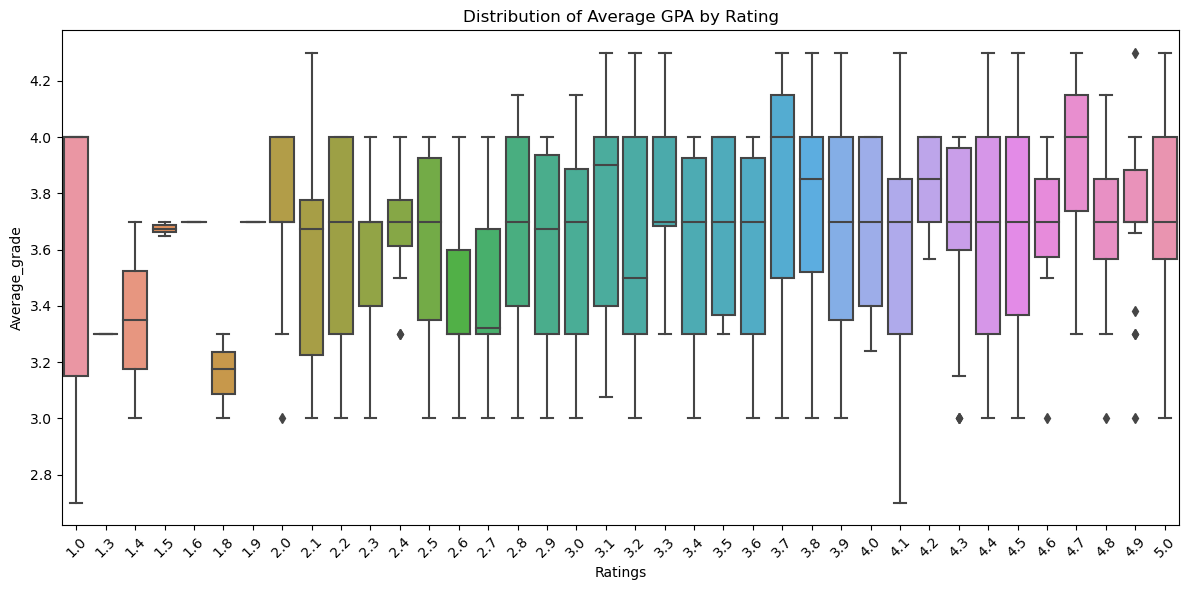

In [332]:
# 7. Distribution of average GPA by rating

#Create the box plot
#Adjust the figure size for better visibility
plt.figure(figsize=(12, 6))  
sns.boxplot(x=df_sorted['Ratings'], y=df_sorted['Average_grade'])

# Set the title and rotate the x-axis labels
plt.title('Distribution of Average GPA by Rating')
plt.xticks(rotation=45)  # Rotate the x-axis labels

plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

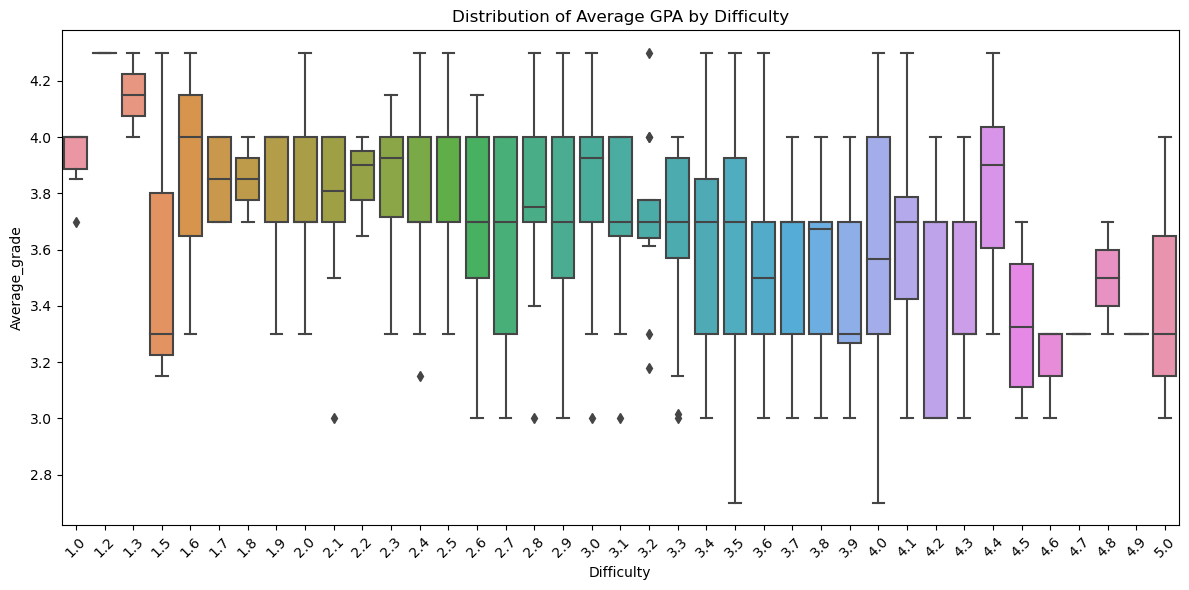

In [333]:
# 8. Distribution of average GPA by difficulty

# Create the box plot
# Adjust the figure size for better visibility
plt.figure(figsize=(12, 6)) 
sns.boxplot(x=df_sorted['Difficulty'], y=df_sorted['Average_grade'])

# Set the title and rotate the x-axis labels
plt.title('Distribution of Average GPA by Difficulty')
plt.xticks(rotation=45)  # Rotate the x-axis labels

plt.tight_layout()  # Ensure everything fits without overlap
plt.show()

Regression Coefficients: [0.05222888]
Intercept: 3.4734269676776086


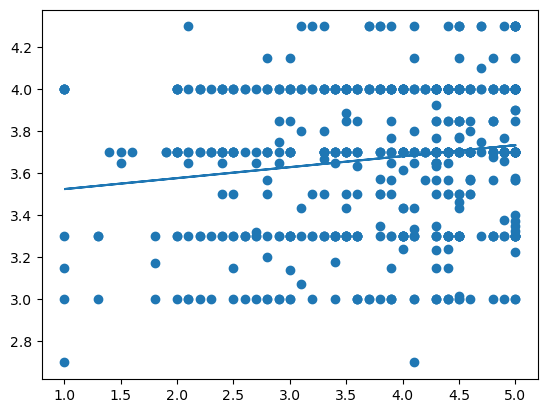

In [334]:
#9 Linear Regression of ratings and average median grades, 
#using ratings to predict average grades
x = df['Ratings'].values.reshape(-1, 1)
y = df['Average_grade']
reg = LinearRegression().fit(x, y)
print(f'Regression Coefficients: {reg.coef_}')
print(f'Intercept: {reg.intercept_}')
plt.scatter(x, y)
plt.plot(x, reg.predict(x))

Regression Coefficients: [-0.14779736]
Intercept: 4.133985668984538


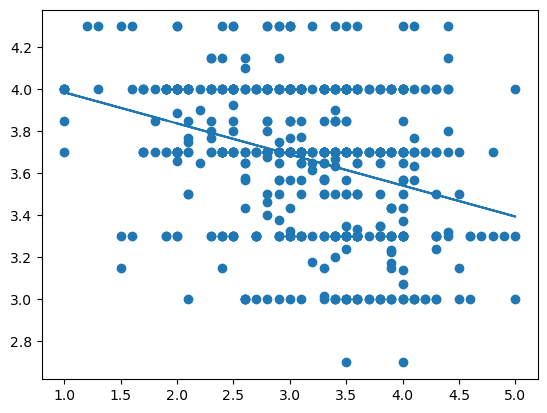

In [335]:
#10 Linear Regression of level of difficulty and average median grades,
#using difficulty to predict average grades
x = df['Difficulty'].values.reshape(-1, 1)
y = df['Average_grade']
reg = LinearRegression().fit(x, y)
print(f'Regression Coefficients: {reg.coef_}')
print(f'Intercept: {reg.intercept_}')
plt.scatter(x, y)
plt.plot(x, reg.predict(x))

#DATA DESCRIPTION

SOURCES:

INSPIRATIONS:
RateMyProfessor/Reddit/CUReview data correlation/accuracy to grade distribution (course reviews). 
https://www.cureviews.org/
https://www.ratemyprofessors.com/school/298
https://www.reddit.com/r/Cornell/ 

GRADE MEDIANS:
https://docs.google.com/spreadsheets/d/1817WfShAi7RHWWJR2c95YUgX37TkjUsLQMYSWhTy9PQ/edit#gid=1481854826

SCRAPING RMP:
https://github.com/tisuela/ratemyprof-api
https://pypi.org/project/RateMyProfessorAPI/


MOTIVATION

• For what purpose was the dataset created? Was there a specific task
in mind? Was there a specific gap that needed to be filled? Please provide
a description.
This dataset was created to observe and analyze the relationship between Cornell University’s professor and their median grades for their classes. It allows us to track a professor’s difficulty, rating, and average median grades for their students across multiple classes that they have taught. We want to investigate how a professor's ratings impact the grade distribution of the class and how a professor’s overall rating and level of difficulty predict the instructor’s grade point average. 
• Who created the dataset (e.g., which team, research group) and on
behalf of which entity (e.g., company, institution, organization)?
• Who funded the creation of the dataset? If there is an associated
grant, please provide the name of the grantor and the grant name and
number

The raw dataset of median grades by class was created and updated by various students of Cornell University on behalf of Cornell University.
The main source of funding for this dataset comes from the website RateMyProfessor and from a self-reported dataset on Google Sheets, which is updated and self-reported by students. We obtained the data from the website through an API and the Google Sheets from a Teaching Assistant. The raw data is sourced from the Cornell University student population.

COMPOSITION

• What do the instances that comprise the dataset represent (e.g.,
documents, photos, people, countries)? Are there multiple types of
instances (e.g., movies, users, and ratings; people and interactions between them; nodes and edges)? Please provide a description.

The instances of the dataset represent the relationships between the ratings/difficulty of Cornell professors on RateMyProfessor and the average median of how well students actually do in terms of grades. The types of instances include names, ratings, difficulty, and number of reviews of professors and the average median grades students received. 

• How many instances are there in total (of each type, if appropriate)?

There are five instances in total: professor name, professor rating, professor difficulty, number of reviews for each professor, and grade point average students received by professors. 

• What data does each instance consist of? “Raw” data (e.g., unprocessed text or images) or features? In either case, please provide a description.

The instance of professor names consists of the last names of professors in string. 
Professor ratings consist of the ratings of each professor on a scale from 1 to 5 in float. 
Difficulty of professors consist of the level of difficulty of each professor on a scale from 1 to 5 in float. 
The professors’ number of ratings consist of the number of ratings each professor received in int. 
The average median grades of students consist of great point average students received by  professors in float. 

• Is any information missing from individual instances? If so, please
provide an explaining why this information is missing (e.g.,
because it was unavailable). This does not include intentionally removed
information, but might include, e.g., redacted text.

The raw dataset of median grades by class has some missing data (NaN) in the columns of professor, grade, and number of students because they are unavailable in the get go. Moreover, the merged dataset had zeros in the column of “Num_reviews”, which indicates that the corresponding professors do not have a rating on RateMyProfessor. We eventually eliminated these rows for a more polished version of our dataset.    

• Are there any errors, sources of noise, or redundancies in the
dataset? If so, please provide a description.

Professor Van Es appears twice in the “Professor” column because the cases of his name does not match. For example, one name is “van Es,” and the other is “Van Es”. This is the only minor issue we have with our dataset.

• Is the dataset self-contained, or does it link to or otherwise rely on
external resources (e.g., websites, tweets, other datasets)? If it links
to or relies on external resources, a) are there guarantees that they will
exist, and remain constant, over time; b) are there official archival versions
of the complete dataset (i.e., including the external resources as they
existed at the time the dataset was created); c) are there any restrictions
(e.g., licenses, fees) associated with any of the external resources that
might apply to a dataset consumer? Please provide descriptions of all
external resources and any restrictions associated with them, as well as
links or other access points, as appropriate.

The merged dataset contains the raw data of median grades by class and the data retrieved from the RateMyProfessor API. It is an individual dataset that does not link to any external resources, but we did get our professor's ratings and the difficulty from https://www.ratemyprofessors.com/ using the API.
Since we use the website’s data to complete our dataset, we cannot guarantee that the content will remain constant since anyone could give a new rating any day. Also, this dataset only accounted for semesters from the past 2-3 years, so there might even be an update on the raw dataset of median grades by class. 
We do not have official archival versions for our dataset since students create and update one while the ratings and difficulty are retrieved using an API. 
Our dataset has no restrictions like licenses or fees.

• Does the dataset contain data that might be considered sensitive
in any way (e.g., data that reveals race or ethnic origins, sexual orientations, religious beliefs, political opinions or union memberships, or locations; financial or health data; biometric or genetic
data; forms of government identification, such as social security
numbers; criminal history)? If so, please provide a description.

Our dataset contains students’ median grade point average corresponding to the instructing professor, which may be sensitive for some students. 

COLLECTION PROCESS

How was the data associated with each instance acquired? Was the data directly observable (e.g., raw text, movie ratings), reported by subjects (e.g., survey responses), or indirectly inferred/derived from other data (e.g., part-of-speech tags, model-based guesses for age or language)? 

The columns of the data frame are as follows: Professor, Average_grade, Ratings, Difficulty, and Num_reviews. Data in the columns of Professor and Average_grade were acquired from the raw dataset of median grades by class. On the other hand, the data of Ratings, Difficulty, and Num_reviews were acquired from the RateMyProfessor API. 

If the data was reported by subjects or indirectly inferred/derived from other data, was the data validated/verified? If so, please describe how. 

The data reported by subjects was not verified. We are unable to do this because the data is completely anonymous and we are not able to access files containing the grades of students for these classes and professors. 	

What mechanisms or procedures were used to collect the data (e.g., hardware apparatuses or sensors, manual human curation, software programs, software APIs)? How were these mechanisms or procedures validated? 

We used a Python API to web scrape RateMyProfessor from https://docs.google.com/spreadsheets/d/1817WfShAi7RHWWJR2c95YUgX37TkjUsLQMYSWhTy9PQ/edit#gid=1481854826. The performance of the API was verified through extensive testing by checking the information returned from the API with the website. The median grades for classes were obtained from the Google Sheets directly using the Pandas library.  

Who was involved in the data collection process (e.g., students, crowdworkers, contractors) and how were they compensated (e.g., how much were crowdworkers paid)? 

Only students were involved in the collection process. They self-reported reviews and grades for the classes and professors. They were not compensated as everything was unpaid.

Over what timeframe was the data collected? 

The data was collected over the timeframe of Fall 2016 to Spring 2033.

Did you collect the data from the individuals in question directly, or obtain it via third parties or other sources (e.g., websites)? Were the individuals in question notified about the data collection? If so, please describe (or show with screenshots or other information) how notice was provided, and provide a link or other access point to, or otherwise reproduce, the exact language of the notification itself. 

The people that are involved in the data collection are unaware of the data collection for our specific use of the data. The data on RateMyProfessor are self-reported by students who submit with the intention that they are submitting a rating for a professor to report overall opinions and personal experiences that they had with a specific professor in a specific class. This means that the reviews submitted on RateMyProfessor are submitted with no knowledge of our data analysis. 

PREPROCESSING/CLEANING/LABELING

Was any preprocessing/cleaning/labeling of the data done (e.g., discretization or bucketing, tokenization, part-of-speech tagging, SIFT feature extraction, removal of instances, processing of missing values)? If so, please provide a description. If not, you may skip the remaining questions in this section. 

One part of the process that influenced what data was not observed and recorded is how we merged the data points. Since the Google Sheets contained less professors than the RateMyProfessor data we are recording only the professors found in the Google Sheets. Another part of the process that influenced what data was not observed was when we had to drop na values in the data frame gathered from the Google Sheets since it contained missing values. This means that we had to remove rows of data where there was an instance of na from our observation. In addition, we also had to remove rows where the column values for Num_reviews was 0 which removed professors with no reviews on RateMyProfessor from our observations. We also took the average of median grades across all of the classes taught by the professor meaning that we only observe the average of median grades rather than individual grades. 

Was the “raw” data saved in addition to the preprocessed/cleaned/labeled data (e.g., to support unanticipated future uses)? If so, please provide a link or other access point to the “raw” data. 

The raw source data for the Google Sheets of self-reported median grades for Cornell University classes can be found at https://docs.google.com/spreadsheets/d/1817WfShAi7RHWWJR2c95YUgX37TkjUsLQMYSWhTy9PQ/edit#gid=1481854826. The raw source data for the API that web scrapes the RateMyProfessor website for rating, difficulty, and number of reviews can be found at https://github.com/tisuela/ratemyprof-api.

Is the software that was used to preprocess/clean/label the data available? If so, please provide a link or other access point.

The API that we used to web scrape information about professors from RateMyProfessor can be found at https://github.com/tisuela/ratemyprof-api.  

USES

What (other) tasks could the dataset be used for?

The dataset could also be used for professor evaluation and their performance and overall Cornell University student performance on classes. 

Is there anything about the composition of the dataset or the way it was collected and preprocessed/cleaned/labeled that might impact future uses? For example, is there anything that a dataset consumer might need to know to avoid uses that could result in unfair treatment of individuals or groups (e.g., stereotyping, quality of service issues) or other risks or harms (e.g., legal risks, financial harms)? If so, please provide a description. Is there anything a dataset consumer could do to mitigate these risks or harms? 

The dataset becomes more and more outdated as more semesters pass by since the dataset records only the data for the semesters from FA16 to SP23. 

Are there tasks for which the dataset should not be used? If so, please provide a description. 

The dataset should not be used for investigating the correlation between the opinions of a professor and the average median grades of each of the classes for universities other than Cornell University. 

DATA LIMITATIONS

One limitation that we encountered for our data was the biases that can be found in the datasets of the RateMyProfessor ratings and the median grades of each class taught by a professor. 

RateMyProfessors is a website based on self-reporting data by students of Cornell which means that the ratings posted tend to be posted by students who are on the extreme ends of opinions on a professor. Students who really like a professor or really hate a professor are more likely to submit a rating and skew the data more towards extreme ends. 

A limitation for the median grades of each class is similar in that it is also a self-reported data set (dataset created and updated by students) which means that students who did better on classes are more likely to submit their grades making the data more biased towards the upper end of grades in the class. 

Another limitation we encountered was that there were more ratings on professors in the RateMyProfessor than there were for the dataset for the median grade which means not all of the professors on RateMyProfessor can be used as analysis for the comparison between professor rating and the grade distribution of their class.

Another limitation is that the dataset contains median grades and professor reviews from the COVID-19 pandemic years where opinions and grades of professors and classes are affected by quarantine and online learning. This can skew the results for certain classes for certain years and make certain comparisons of data points inaccurate. 

Another limitation is that the median grades are in letters, so the grades are not as accurate as we desired. 

Another limitation is that these datasets are constantly being updated daily. This means that our datasets will become more outdated by time and will need to be re fetched and recleaned for our data and analysis to be accurate.

Another limitation is that certain professors and classes are more popular than others meaning that certain classes would have more data than others. This could lead to discrepancies in our analysis of data across different classes and professors.

The datasets used are only for Cornell University classes and professors meaning that the results and conclusions from the analysis cannot be accurately translated to professors and classes of other universities.

Our datasets depend heavily on RateMyProfessor and the self-reported Google Sheets for median grades of Cornell University classes. This means that if any classes or professors are missing from either of the dataset we are unable to include their data in our analysis. 

Another limitation is that the data for both datasets are self-reported meaning that there can be false data points being reported and we cannot find out which ones are untrue and which ones are true.

Another limitation is that there is human error contained within the Google Sheets. This means that some of the data has missing column values which forces us to exclude the data point from the final data frame. Some of the professor names were spelt incorrectly and some of the professor names were listed in an incorrect and ambiguous format. One example was how “various professors” was the value of the name of the professor column. This means that we will inevitably lose data points in the process.

QUESTIONS FOR REVIEWERS:

How can we account for the biases in our dataset?

What predictions can we make using the dataset? 

How can we account for the COVID years in our dataset?

What other variables should we include in our dataset? Should we include the semester taught, years of experience, or the subject of the class?

Are there any alternative datasets that are a better fit for our project?

Is it statistically appropriate to take the means of medians to create conclusions about the dataset?
